Base Algorithm

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio

class Parameters:
    def __init__(self, b1, b2, k1, k2, c12, c21, z_m1_initial, z_m2_initial, initial_population_species_1, initial_population_species_2, cost_to_males, strength_of_interference, V_A1, V_A2, num_generations):
        self.b1 = b1
        self.b2 = b2
        self.k1 = k1
        self.k2 = k2
        self.c12 = c12
        self.c21 = c21
        self.z_m1_initial = z_m1_initial
        self.z_m2_initial = z_m2_initial
        self.initial_population_species_1 = initial_population_species_1
        self.initial_population_species_2 = initial_population_species_2
        self.cost_to_males = cost_to_males
        self.strength_of_interference = strength_of_interference
        self.V_A1 = V_A1
        self.V_A2 = V_A2
        self.num_generations = num_generations

class Simulation:
    def __init__(self, params):
        self.params = params
        self.population_species_history_1 = [params.initial_population_species_1]
        self.population_species_history_2 = [params.initial_population_species_2]
        self.z_m1_history = [params.z_m1_initial]
        self.z_m2_history = [params.z_m2_initial]
        self.z_m1 = params.z_m1_initial
        self.z_m2 = params.z_m2_initial

    def next_generation_ecology(self):
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        
        if N1 > 0.01:
            next_N1 = self.params.b1 * (N1 / 2) * (N1 / (N1 + self.params.strength_of_interference * (1 - self.z_m2) * N2)) - (self.params.k1 * N1 * (N1 + self.params.c12 * N2))
            next_N1 = max(next_N1, 0)
        else:
            next_N1 = 0 
        
        if N2 > 0.01:
            next_N2 = self.params.b2 * (N2 / 2) * (N2 / (N2 + self.params.strength_of_interference * (1 - self.z_m1) * N1)) - (self.params.k2 * N2 * (N2 + self.params.c21 * N1))
            next_N2 = max(next_N2, 0)
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0.01:
            W_m1 = 1 - (self.params.cost_to_males * (1 - self.z_m1) * (N2 / (N2 + N1)))
            dW_m1_dz_m2 = self.params.cost_to_males * (N2 / (N2 + N1))
            delta_z_m1 = self.params.V_A1 * (1 / W_m1) * dW_m1_dz_m2
            new_z_m1 = self.z_m1 + delta_z_m1
            
            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1
            else :
                self.z_m1 = 1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0.01:
            W_m2 = 1 - (self.params.cost_to_males * (1 - self.z_m2) * (N2 / (N2 + N1)))
            dW_m2_dz_m2 = self.params.cost_to_males * (N1 / (N1 + N2))
            delta_z_m2 = self.params.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2
            else :
                self.z_m2 = 1

            self.z_m2_history.append(self.z_m2)

    def next_generation(self):
        self.next_generation_ecology()
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        self.next_generation_traits(N1, N2)
        return N1, N2

    def run_simulation(self):
        for t in range(self.params.num_generations - 1):
            N1, N2 = self.next_generation()
            if N1 < 0.01 or N2 < 0.01:
                break

        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history

class outcome_stats_and_plots:
    def __init__(self, population_species_1, population_species_2, z_m1_history, z_m2_history, params):
        self.population_species_1 = population_species_1
        self.population_species_2 = population_species_2
        self.z_m1_history = z_m1_history
        self.z_m2_history = z_m2_history
        self.params = params

        self.outcome = None
        self.number_of_generations_until_extinctioin = None
        self.final_population_species_1 = None
        self.final_population_species_2 = None
        self.final_z_m1 = None
        self.final_z_m2 = None

        self.outcome_stats()

    def plot_population_dynamics_and_trait_evolution(self):
        self.plot_population_dynamics()
        self.plot_traits_evolution()

    def plot_population_dynamics(self):
        fig = go.Figure()

        # Population Species 1
        fig.add_trace(go.Scatter(x=list(range(len(self.population_species_1))), 
                                 y=self.population_species_1, 
                                 mode='lines', 
                                 name='Species 1 (Slow-ev)', 
                                 line=dict(color='blue')))

        # Population Species 2
        fig.add_trace(go.Scatter(x=list(range(len(self.population_species_2))), 
                                 y=self.population_species_2, 
                                 mode='lines', 
                                 name='Species 2 (Fast-ev)', 
                                 line=dict(color='red')))

        fig.update_layout(
            title='Population Dynamics of Two Competing Species',
            xaxis_title='Time',
            yaxis_title='Population',
            legend_title='Species',
            template='plotly'  # Set the dark theme
        )

        pio.show(fig)  # Use pyo.plot for script execution, pio.show for Jupyter Notebooks

    def plot_traits_evolution(self):
        fig = go.Figure()

        # Mean Trait z_m1
        fig.add_trace(go.Scatter(x=list(range(len(self.z_m1_history))), 
                                 y=self.z_m1_history, 
                                 mode='lines', 
                                 name='Mean Trait z_m1', 
                                 line=dict(color='blue')))

        # Mean Trait z_m2
        fig.add_trace(go.Scatter(x=list(range(len(self.z_m2_history))), 
                                 y=self.z_m2_history, 
                                 mode='lines', 
                                 name='Mean Trait z_m2', 
                                 line=dict(color='red')))

        fig.update_layout(
            title='Evolution of Traits',
            xaxis_title='Generation',
            yaxis_title='Mean Trait Value',
            legend_title='Traits',
            template='plotly'  # Set the dark theme
        )

        pio.show(fig)  # Use pyo.plot for script execution, pio.show for Jupyter Notebooks

    def outcome_stats(self):

        if self.population_species_1[-1] < 0.01 and self.population_species_2[-1] < 0.01:
            self.outcome = "both extinct"
        elif self.population_species_1[-1] < 0.01 and self.population_species_2[-1] > 0.01:
            self.outcome = "sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct"
        elif self.population_species_2[-1] < 0.01 and self.population_species_1[-1] > 0.01:
            self.outcome = "sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct"
        else:
            self.outcome = "both coexist"

        if len(self.population_species_1) < self.params.num_generations:
            self.number_of_generations_until_extinctioin = len(self.population_species_1)
            self.final_population_species_1 = self.population_species_1[-1]
            self.final_population_species_2 = self.population_species_2[-1]
            self.final_z_m1 = self.z_m1_history[-1]
            self.final_z_m2 = self.z_m2_history[-1]

    def print_outcome_stats(self):

        print("Outcome of simulation: ", self.outcome)    
        print("Number of generations until extinction: ", self.number_of_generations_until_extinctioin)
        print("Final population of species 1: ", self.final_population_species_1)
        print("Final population of species 2: ", self.final_population_species_2)
        print("Final trait value z_m1: ", self.final_z_m1)
        print("Final trait value z_m2: ", self.final_z_m2)

def run_simulation_and_plot_pop_dynamics_and_trait_evolution(outcome_stats_and_plots_instance):
    outcome_stats_and_plots_instance.plot_population_dynamics_and_trait_evolution()
    outcome_stats_and_plots_instance.print_outcome_stats()

def run_simulation_and_get_outcome_instance(params):
    simulation = Simulation(params)
    population_species_1, population_species_2, z_m1_history, z_m2_history = simulation.run_simulation()
    outcome_stats_and_plots_instance = outcome_stats_and_plots(population_species_1, population_species_2, z_m1_history, z_m2_history, params)
    
    return outcome_stats_and_plots_instance




Species 2 - Fast Evolving. Species 1 - Slow evolving

Base Parameters Simulation

In [90]:
# Parameters
base_parameters = Parameters(
    b1 = 2.3, 
    b2 = 2.3, 
    k1 = 0.0001, 
    k2 = 0.0001, 
    c12 = 1.1, 
    c21 = 1.1, 
    z_m1_initial = 0, 
    z_m2_initial = 0, 
    initial_population_species_1 = 1000, 
    initial_population_species_2 = 1000, 
    cost_to_males = 0.1,
    strength_of_interference = 0.1,
    V_A1 = 0.01, 
    V_A2 = 0.1, 
    num_generations = 10000
)

outcome_instance = run_simulation_and_get_outcome_instance(base_parameters)
outcome_instance.plot_population_dynamics_and_trait_evolution()
outcome_instance.print_outcome_stats()




Outcome of simulation:  sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct
Number of generations until extinction:  34
Final population of species 1:  775.2929496440105
Final population of species 2:  0
Final trait value z_m1:  0.012353960499605814
Final trait value z_m2:  0.20828304470811104


In [91]:
test_parameters = Parameters(
    b1 = 2.3, 
    b2 = 2.3, 
    k1 = 0.0001, 
    k2 = 0.0001, 
    c12 = 0.9, 
    c21 = 0.9, 
    z_m1_initial = 1, 
    z_m2_initial = 1, 
    initial_population_species_1 = 1000, 
    initial_population_species_2 = 1000, 
    cost_to_males = 0.1,
    strength_of_interference = 0.1,
    V_A1 = 0.0, 
    V_A2 = 0.0, 
    num_generations = 10000
)

outcome_instance_test = run_simulation_and_get_outcome_instance(test_parameters)
print(print("Outcome of simulation: ", outcome_instance_test.outcome)
)
outcome_instance_test.plot_population_dynamics_and_trait_evolution()
outcome_instance_test.print_outcome_stats()


Outcome of simulation:  both coexist
None


Outcome of simulation:  both coexist
Number of generations until extinction:  None
Final population of species 1:  None
Final population of species 2:  None
Final trait value z_m1:  None
Final trait value z_m2:  None


Sensitivity Analysis


Running sensitivity analysis for b1...


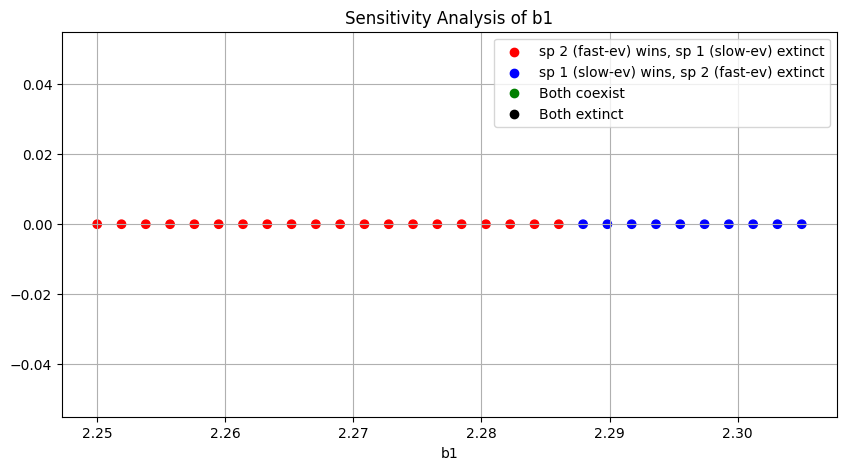

Running sensitivity analysis for b2...


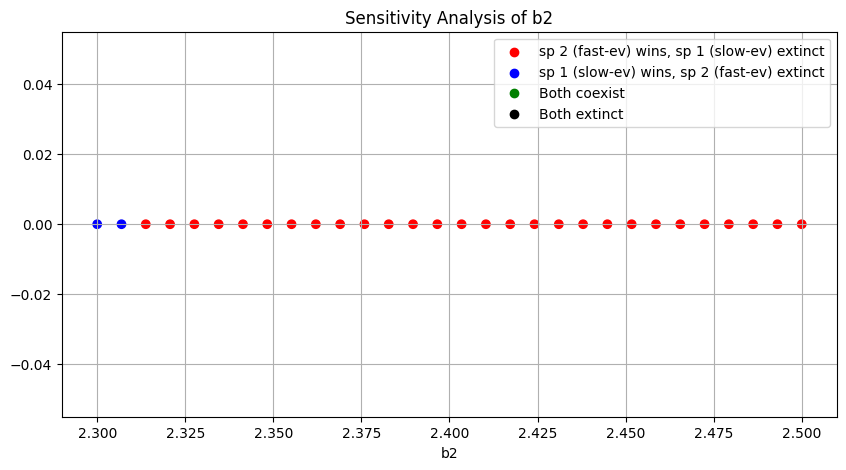

Running sensitivity analysis for k1...


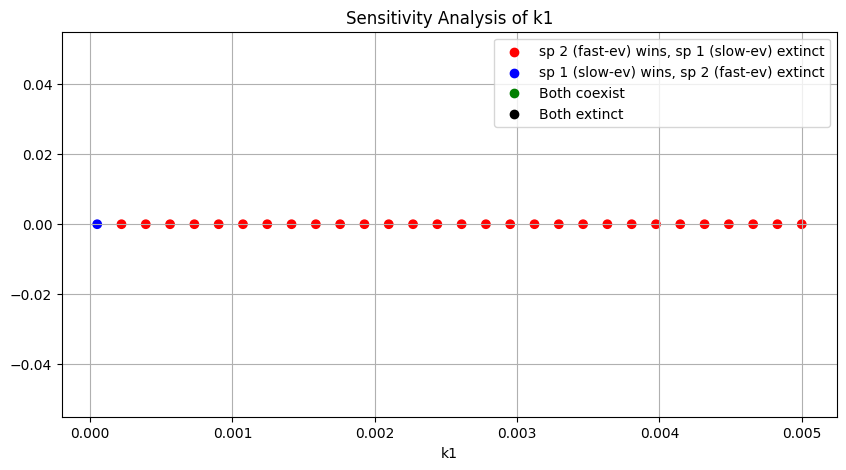

Running sensitivity analysis for k2...


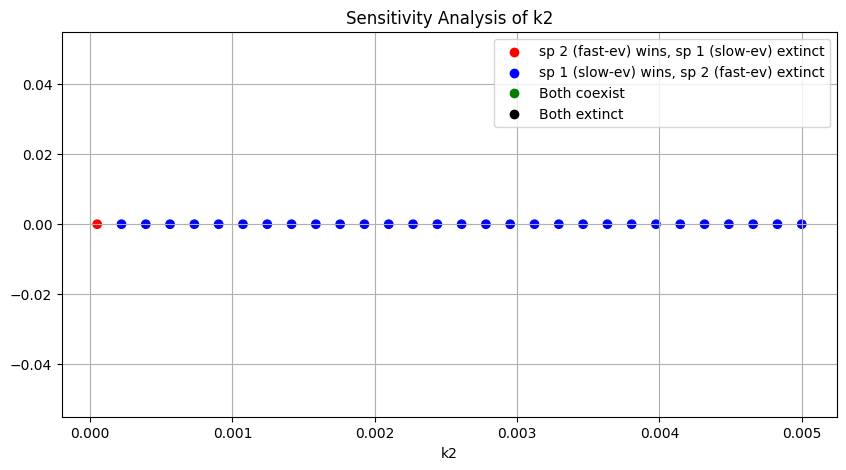

Running sensitivity analysis for c12...


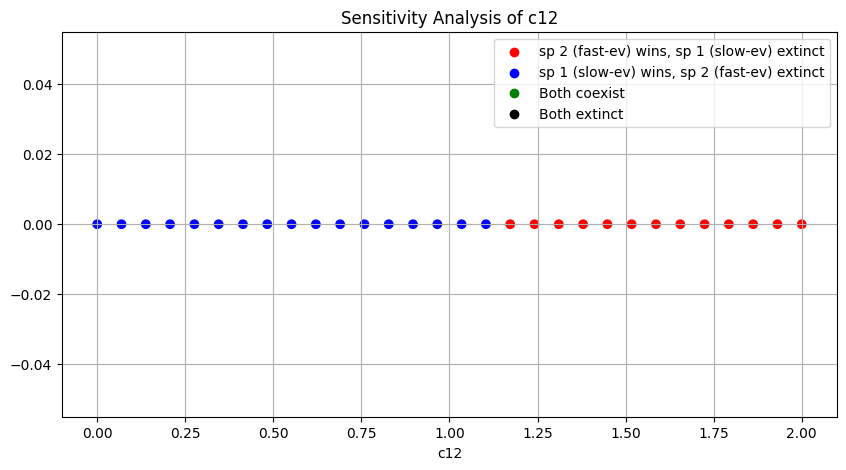

Running sensitivity analysis for c21...


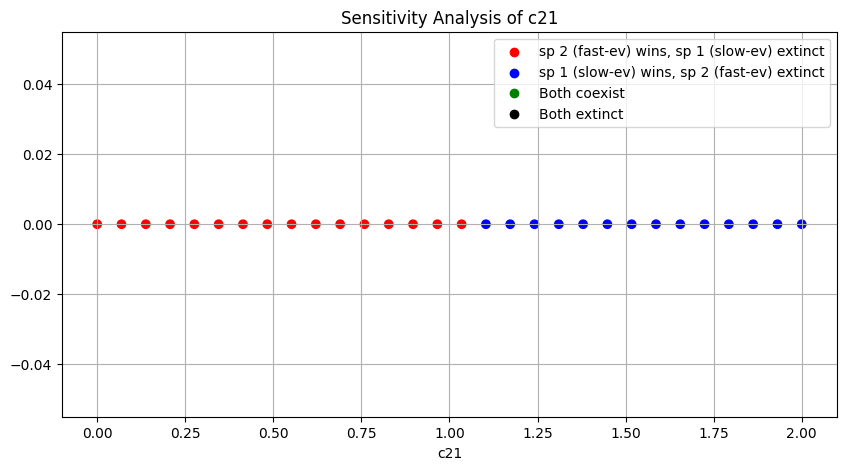

Running sensitivity analysis for z_m1_initial...


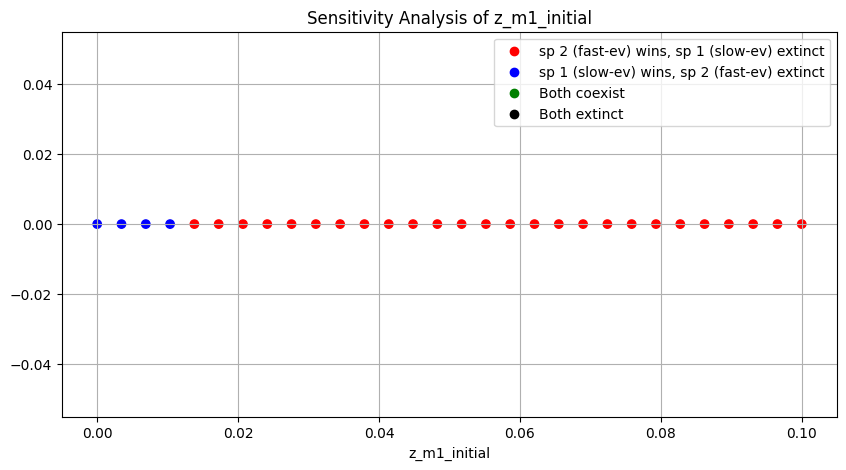

Running sensitivity analysis for z_m2_initial...


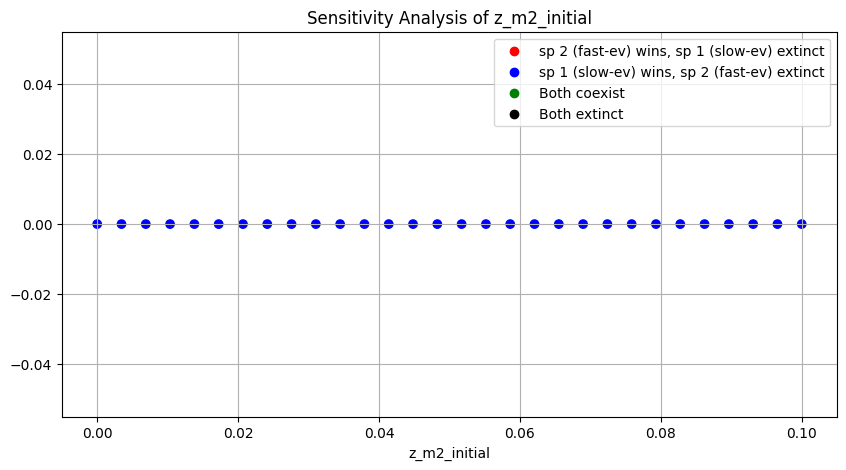

Running sensitivity analysis for cost_to_males...


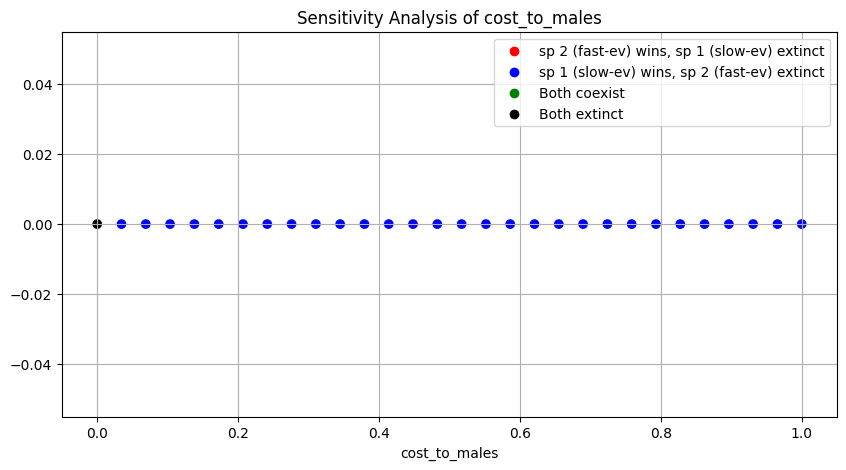

Running sensitivity analysis for strength_of_interference...


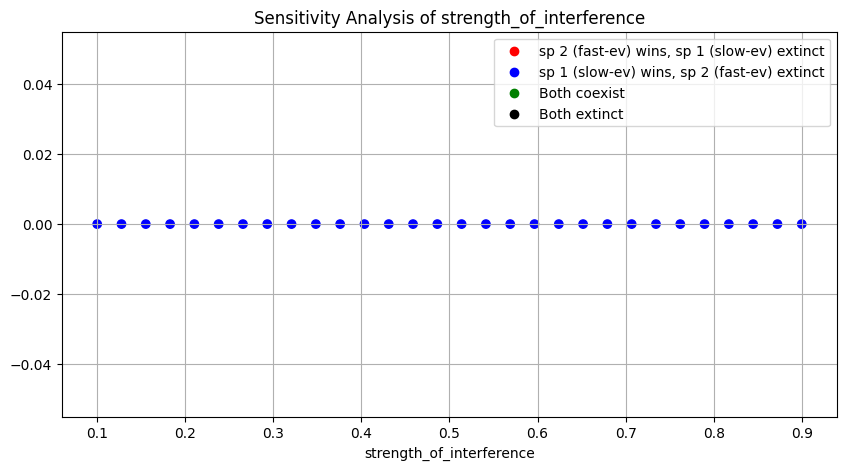

Running sensitivity analysis for V_A1...


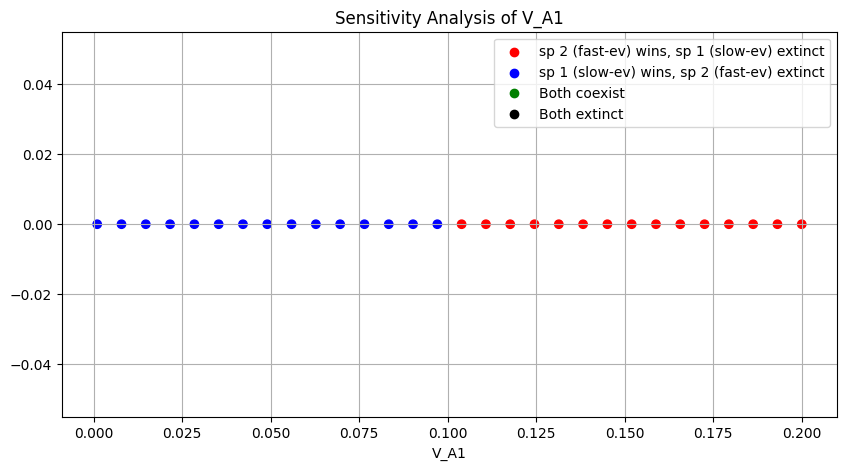

Running sensitivity analysis for V_A2...


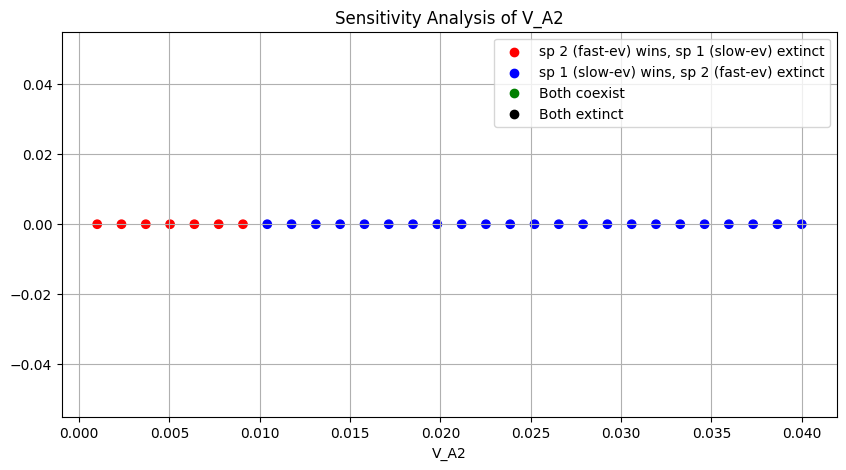

'\n1. birth rate - super sensitive\n2. k - fast species will win if k increases for the slow species or k decreases for the fast species. Again sensitive - 0.0001 difference\n3. c12 - fast species will beyone 1.25\n4. c21 - fast species wins if c21 falls below 1\n\n\n\n'

In [92]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters_for_Analysis:   #class - if the argument has a value for parameter x it takes that value, otherwise it takes the default value
    def __init__(self, **kwargs):
        self.b1 = kwargs.get('b1', 2.3)
        self.b2 = kwargs.get('b2', 2.3)
        self.k1 = kwargs.get('k1', 0.0001)
        self.k2 = kwargs.get('k2', 0.0001)
        self.c12 = kwargs.get('c12', 1.1)
        self.c21 = kwargs.get('c21', 1.1)
        self.z_m1_initial = kwargs.get('z_m1_initial', 0)
        self.z_m2_initial = kwargs.get('z_m2_initial', 0)
        self.initial_population_species_1 = kwargs.get('initial_population_species_1', 1000)
        self.initial_population_species_2 = kwargs.get('initial_population_species_2', 1000)
        self.cost_to_males = kwargs.get('cost_to_males', 0.3)
        self.strength_of_interference = kwargs.get('strength_of_interference', 1)
        self.V_A1 = kwargs.get('V_A1', 0.01)
        self.V_A2 = kwargs.get('V_A2', 0.1)
        self.num_generations = kwargs.get('num_generations', 1000)

def plot_sensitivity_analysis(param_values, final_outcomes_list, param_name):  
        color_map = {"sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct": 'red', "sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct": 'blue', "both extinct"
: 'black', "both coexist": 'green'}
        
        colors = [color_map[outcome] for outcome in final_outcomes_list]
        
        plt.figure(figsize=(10, 5))
        plt.scatter(param_values, [0]*len(param_values), color=colors, marker='o')
        plt.xlabel(param_name)
        plt.title(f'Sensitivity Analysis of {param_name}')
        plt.grid(True)
        # Adding legend manually
        plt.scatter([], [], color='red', label="sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct")
        plt.scatter([], [], color='blue', label= "sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct")
        plt.scatter([], [], color='green', label='Both coexist')
        plt.scatter([], [], color='black', label='Both extinct')
        plt.legend(loc='upper right')
        plt.show()

def generate_parameters_with_varied_param(param_name, param_values):  #base params, param name taken, and the different values of that parameter are taken
    params_list = []
    for value in param_values:   
        params_dict = Parameters_for_Analysis().__dict__.copy() #create a default instance of the Parameters_for_Analysis class and then copy the dictionary of the instance
        params_dict[param_name] = value             #Thuis dictionary is then inserted into the Parameters_for_Analysis class which creates yet abother instance
        params = Parameters_for_Analysis(**params_dict)
        params_list.append(params)      #all the instances are appended to a list
    return params_list

def run_sensitivity_analysis(params_list):
    final_outcomes_list = []
    for params in params_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(params)
        final_outcomes_list.append(final_outcome_instance.outcome)
    return final_outcomes_list

def main():
    # Base Parameters

    # Parameters to vary
    param_ranges = {                  #for each parameter name, the range of values to vary over is definedm as a dictionary
        'b1': np.linspace(2.25, 2.305, 30),
        'b2': np.linspace(2.3, 2.5, 30),
        'k1': np.linspace(0.00005, 0.005, 30),
        'k2': np.linspace(0.00005, 0.005, 30),
        'c12': np.linspace(0, 2, 30),
        'c21': np.linspace(0, 2, 30),
        'z_m1_initial': np.linspace(0, 0.1, 30),
        'z_m2_initial': np.linspace(0, 0.1, 30),
        'cost_to_males': np.linspace(0, 1, 30),
        'strength_of_interference': np.linspace(0.1, 0.9, 30),
        'V_A1': np.linspace(0.001, 0.2, 30),
        'V_A2': np.linspace(0.001, 0.04, 30)
    }

    param_names = param_ranges.keys()   #the keys of the param_ranges dictionary are extracted and stored in the param_names list

    for param_name in param_names:      #for each parameter, the sensitivity analysis is run and a corresponding plot is generated
        print(f"Running sensitivity analysis for {param_name}...")
        param_values = param_ranges[param_name]     #the values of the corresponding parameter are extracted from the param_ranges_dictionary        
        params_list = generate_parameters_with_varied_param(param_name, param_values) #params list is a list of instances created with the varied parameter values
        final_outcomes_list = run_sensitivity_analysis(params_list) 
        plot_sensitivity_analysis(param_values, final_outcomes_list, param_name)

if __name__ == "__main__":
    main()



'''
1. birth rate - super sensitive
2. k - fast species will win if k increases for the slow species or k decreases for the fast species. Again sensitive - 0.0001 difference
3. c12 - fast species will beyone 1.25
4. c21 - fast species wins if c21 falls below 1



'''


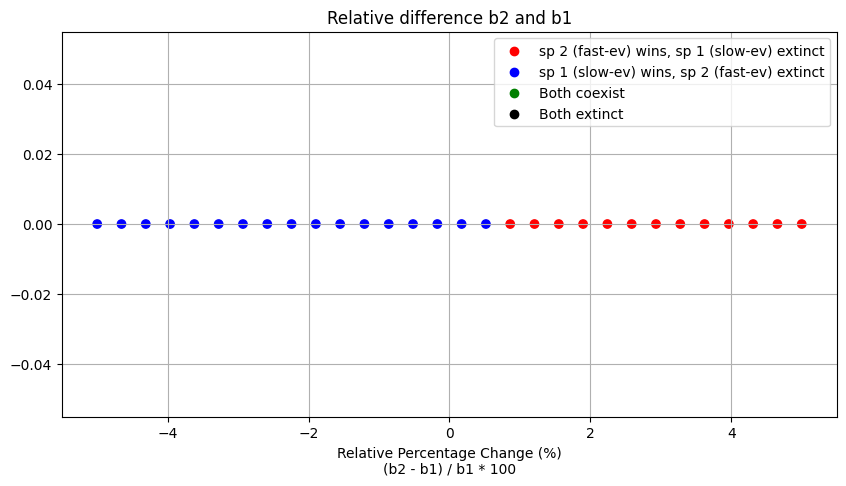

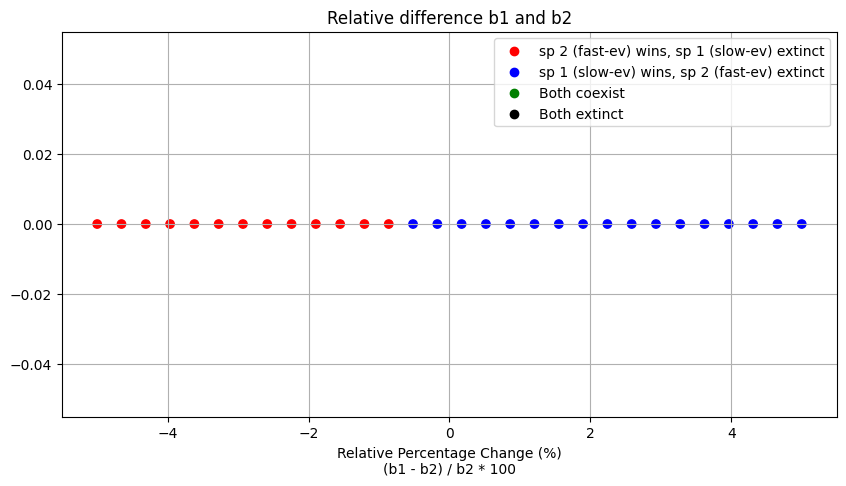

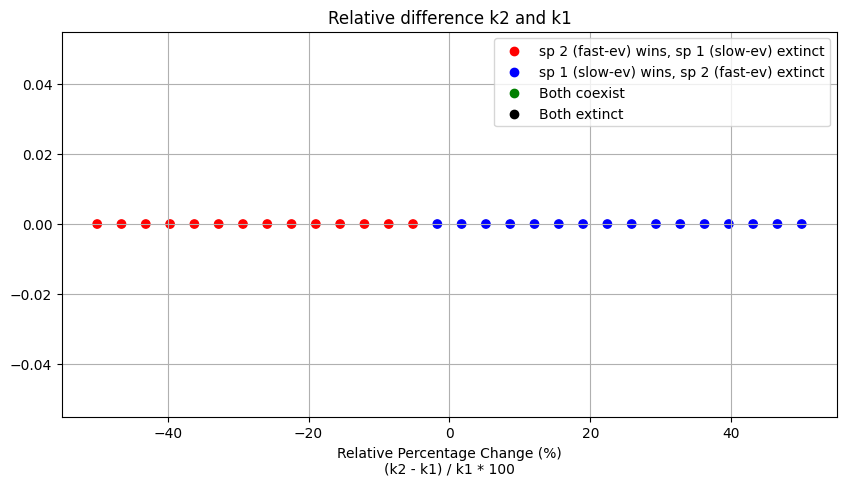

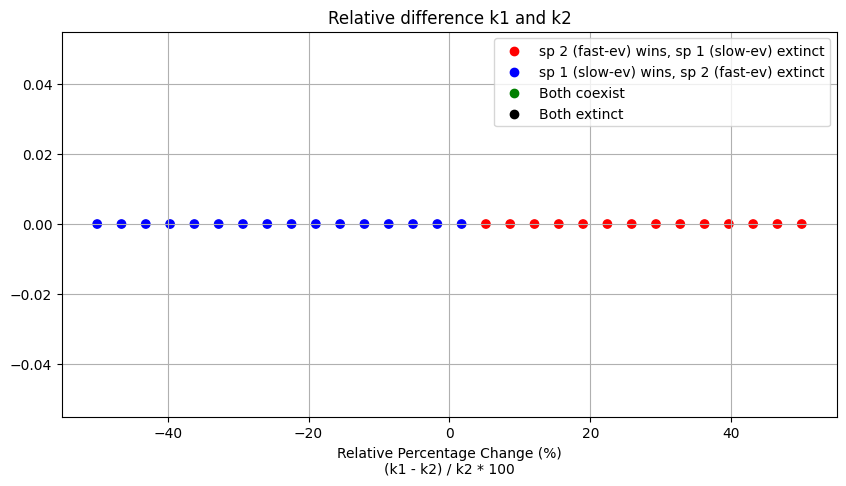

In [93]:
def plot_sensitivity_analysis_comparison(param_values, final_outcomes_list, param_name, baseline_param, comparison_param):
    color_map = {
        "sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct": 'red',
        "sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct": 'blue',
        "both extinct": 'black',
        "both coexist": 'green'
    }
    
    colors = [color_map[outcome] for outcome in final_outcomes_list]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(param_values, [0]*len(param_values), color=colors, marker='o')
    
    plt.xlabel(f'Relative Percentage Change (%)\n({comparison_param} - {baseline_param}) / {baseline_param} * 100')
    plt.title(f'Relative difference {param_name} and {baseline_param}')
    
    plt.grid(True)
    
    # Legend with color labels
    plt.scatter([], [], color='red', label="sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct")
    plt.scatter([], [], color='blue', label="sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct")
    plt.scatter([], [], color='green', label='Both coexist')
    plt.scatter([], [], color='black', label='Both extinct')
    plt.legend(loc='upper right')
    
    plt.show()
def main():
    # Example usage for b2 - b1 comparison
    comparison_birth_rates = [
        ('b2', 'b1'),
        ('b1', 'b2'),
    ]

    comparisons_ks = [  
         ('k2', 'k1'),
        ('k1', 'k2'),
    ]
    
    for comparison_param, baseline_param in comparison_birth_rates:
        baseline_value = Parameters_for_Analysis().__dict__[baseline_param]
        param_values = np.linspace(baseline_value - 0.05 * baseline_value, baseline_value + 0.05 * baseline_value, 30)  # Varying comparison_param
        
        params_list = generate_parameters_with_varied_param(comparison_param, param_values)
        final_outcomes_list = run_sensitivity_analysis(params_list)
        
        transformed_values = ((param_values - baseline_value) / baseline_value) * 100
        plot_sensitivity_analysis_comparison(transformed_values, final_outcomes_list, comparison_param, baseline_param, comparison_param)

    for comparison_param, baseline_param in comparisons_ks:
        baseline_value = Parameters_for_Analysis().__dict__[baseline_param]
        param_values = np.linspace(baseline_value - 0.5 * baseline_value, baseline_value + 0.5 * baseline_value, 30)

        params_list = generate_parameters_with_varied_param(comparison_param, param_values)
        final_outcomes_list = run_sensitivity_analysis(params_list)

        transformed_values = ((param_values - baseline_value) / baseline_value) * 100
        plot_sensitivity_analysis_comparison(transformed_values, final_outcomes_list, comparison_param, baseline_param, comparison_param)


if __name__ == "__main__":
    main()


In [94]:
'''Positive frequency depednance is a major outcome of reproductive interference, assume both are equal in all respects, evolvabilty, initial discrimination, everything. Only initial number of 1 > 2: How does evolvability of traits '''


'''Assume both sp have equal evolvabiilty. uninformly increase evolvability of both species ...'''

evolvability_list = [0, 0.001, 0.01, 0.1, 1, 3]
for evolvability_parameter in evolvability_list:
    params_temp = Parameters(
        b1 = 2.3, 
        b2 = 2.3, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 0, 
        c21 = 0, 
        z_m1_initial = 0, 
        z_m2_initial = 0, 
        initial_population_species_1 = 1000, 
        initial_population_species_2 = 100, 
        cost_to_males = 0.1,
        strength_of_interference = 0.1,
        V_A1 = evolvability_parameter,   #note - ignore fast and slow labels in plots here
        V_A2 = evolvability_parameter, 
        num_generations = 10000
    )

    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()
    print("V_A1 =", params_temp.V_A1  ,"|" , "V_A2 = ", params_temp.V_A2, "|| generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)


'''evolution allows for coexistence despite positive freq depedendance '''

V_A1 = 0 | V_A2 =  0 || generations until extinction =  6


V_A1 = 0.001 | V_A2 =  0.001 || generations until extinction =  6


V_A1 = 0.01 | V_A2 =  0.01 || generations until extinction =  6


V_A1 = 0.1 | V_A2 =  0.1 || generations until extinction =  6


V_A1 = 1 | V_A2 =  1 || generations until extinction =  6


V_A1 = 3 | V_A2 =  3 || generations until extinction =  6


'evolution allows for coexistence despite positive freq depedendance '

In [95]:
'''Positive frequency depednance is a major outcome of reproductive interference, assume both are equal in all respects, evolvabilty, initial discrimination, everything. Only initial number of 1 > 2: How does evolvability of traits '''


'''Assume both sp have equal evolvabiilty. uninformly increase evolvability of both species ...'''
'''keep z1 as 0 and z2 as 1. Which means z1 has a satry effect on 2 (0 indiscrciminate males), but z2 does not have any effect on 1.'''

evolvability_list = [0, 0.001, 0.01, 0.1, 1, 3]
for evolvability_parameter in evolvability_list:
    params_temp = Parameters(
        b1 = 2.3, 
        b2 = 2.3, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 0.5, 
        c21 = 0.5, 
        z_m1_initial = 0, 
        z_m2_initial = 0.5, 
        initial_population_species_1 = 1000, 
        initial_population_species_2 = 1000, 
        cost_to_males = 0.1,
        strength_of_interference = 0.1,
        V_A1 = evolvability_parameter, 
        V_A2 = evolvability_parameter, 
        num_generations = 10000
    )

    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    # outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()
    print("V_A1 =", params_temp.V_A1  ,"|" , "V_A2 = ", params_temp.V_A2, "|| generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)


'''when both species can evolve, the intensity of the satyr effect rduces'''

V_A1 = 0 | V_A2 =  0 || generations until extinction =  19
V_A1 = 0.001 | V_A2 =  0.001 || generations until extinction =  19
V_A1 = 0.01 | V_A2 =  0.01 || generations until extinction =  19
V_A1 = 0.1 | V_A2 =  0.1 || generations until extinction =  20
V_A1 = 1 | V_A2 =  1 || generations until extinction =  28
V_A1 = 3 | V_A2 =  3 || generations until extinction =  None


'when both species can evolve, the intensity of the satyr effect rduces'

In [100]:
'''The slow evolving species wins in the default case. What if the slow evolving species started out as a good discriminator (hence poor initial satyr effect). Fast species initially has good satyr effect, but will soon evolve to become worse'''
z_m1_initial_list = np.arange(0, 0.75, 0.1)
for z_m1_initial_value in z_m1_initial_list:
    params_temp = Parameters(
        b1 = 2.3, 
        b2 = 2.3, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 0, 
        c21 = 0, 
        z_m1_initial = z_m1_initial_value, 
        z_m2_initial = 0, 
        initial_population_species_1 = 1000, 
        initial_population_species_2 = 1000, 
        cost_to_males = 0.1,
        strength_of_interference = 0.1,
        V_A1 = 0.1, 
        V_A2 = 0.5, 
        num_generations = 10000
    )

    outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
    print(outcome_stats_and_plots_instance_temp.outcome)
    print("z_m1_iitial =", params_temp.z_m1_initial)
    outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()


'''Insights: 
1. The slow evolving species wins in the default case.
2. Initial difference in satyr effect matters more than later (stength of satyr effect is depednant on relative population sizes, if population size of a sp. reduces its satyr effect reduces). 
    If V_A1 = 0.01, and V_A2 = 0.1, then the slow evolving species wins. 
3. There is coexistence - wtf (V_A1 = 0.1, V_A2 = 0.5)
4.  The traits crossing each other sometimes determines the outcome, sometimes not

'''


sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct
z_m1_iitial = 0.0


sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct
z_m1_iitial = 0.1


sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct
z_m1_iitial = 0.2


both coexist
z_m1_iitial = 0.30000000000000004


sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct
z_m1_iitial = 0.4


sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct
z_m1_iitial = 0.5


sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct
z_m1_iitial = 0.6000000000000001


sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct
z_m1_iitial = 0.7000000000000001


'Insights: \n1. The slow evolving species wins in the default case.\n2. Initial difference in satyr effect matters more than later (stength of satyr effect is depednant on relative population sizes, if population size of a sp. reduces its satyr effect reduces). \n    If V_A1 = 0.01, and V_A2 = 0.1, then the slow evolving species wins. \n3. There is coexistence - wtf (V_A1 = 0.1, V_A2 = 0.5)\n4.  The traits crossing each other sometimes determines the outcome, sometimes not\n\n'

In [97]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

class Parameters_for_Analysis:
    def __init__(self, **kwargs):
        self.b1 = kwargs.get('b1', 2.3)
        self.b2 = kwargs.get('b2', 2.3)
        self.k1 = kwargs.get('k1', 0.0001)
        self.k2 = kwargs.get('k2', 0.0001)
        self.c12 = kwargs.get('c12', 0.8)
        self.c21 = kwargs.get('c21', 0.8)
        self.z_m1_initial = kwargs.get('z_m1_initial', 0)
        self.z_m2_initial = kwargs.get('z_m2_initial', 0)
        self.initial_population_species_1 = kwargs.get('initial_population_species_1', 1000)
        self.initial_population_species_2 = kwargs.get('initial_population_species_2', 1000)
        self.cost_to_males = kwargs.get('cost_to_males', 0.3)
        self.strength_of_interference = kwargs.get('strength_of_interference', 0.1)
        self.V_A1 = kwargs.get('V_A1', 0.01)
        self.V_A2 = kwargs.get('V_A2', 0.1)
        self.num_generations = kwargs.get('num_generations', 1000)

def plot_2d_sensitivity_analysis(N2_N1_ratios, V2_V1_ratios, final_outcomes_matrix):
    color_map = {"sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct": 'red', "sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct": 'blue', 
                 "both extinct": 'black', "both coexist": 'green'}
    
    colors = np.vectorize(color_map.get)(final_outcomes_matrix)

    traces = []
    for i in range(len(N2_N1_ratios)):
        for j in range(len(V2_V1_ratios)):
            traces.append(go.Scatter(
                x=[N2_N1_ratios[i]], y=[V2_V1_ratios[j]], mode='markers',
                marker=dict(color=colors[i, j]),
                showlegend=False
            ))

    fig = go.Figure(data=traces)

    fig.update_layout(
        title='2D Sensitivity Analysis',
        xaxis=dict(title='N2/N1 Ratio', type='log', tickvals=N2_N1_ratios),
        yaxis=dict(title='V2/V1 Ratio', type='log', tickvals=V2_V1_ratios),
        template='plotly',  # Set the grey theme
        width=1000,
        height=800,
    )

    # Adding legend manually
    legend_labels = [
        ("sp 2 (fast-ev) wins, sp 1 (slow-ev) extinct", 'red'),
        ("sp 1 (slow-ev) wins, sp 2 (fast-ev) extinct", 'blue'),
        ('Both coexist', 'green'),
        ('Both extinct', 'black')
    ]

    for label, color in legend_labels:
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(color=color),
            showlegend=True,
            name=label
        ))

    pio.show(fig)  # Use pio.show to display the plot

def generate_parameters_with_varied_params(N2_N1_ratios, V2_V1_ratios):
    params_list = []
    for N2_N1 in N2_N1_ratios:
        for V2_V1 in V2_V1_ratios:
            params_dict = Parameters_for_Analysis(V_A1=0.01, V_A2=0.01).__dict__.copy()
            params_dict['initial_population_species_2'] = params_dict['initial_population_species_1'] * N2_N1
            params_dict['V_A2'] = params_dict['V_A1'] * V2_V1
            params = Parameters_for_Analysis(**params_dict)
            params_list.append(params)
    return params_list

def run_sensitivity_analysis(params_list):
    final_outcomes_list = []
    for params in params_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(params)
        final_outcomes_list.append(final_outcome_instance.outcome)
    return final_outcomes_list

def main():
    N2_N1_powers = np.arange(-3, 1.5, 0.125)
    V2_V1_powers = np.arange(0, 3, 0.125)
    
    N2_N1_ratios = np.power(10.0, N2_N1_powers)
    V2_V1_ratios = np.power(10.0, V2_V1_powers)
    
    params_list = generate_parameters_with_varied_params(N2_N1_ratios, V2_V1_ratios)
    final_outcomes_list = run_sensitivity_analysis(params_list)
    
    final_outcomes_matrix = np.array(final_outcomes_list).reshape(len(N2_N1_ratios), len(V2_V1_ratios))
    
    plot_2d_sensitivity_analysis(N2_N1_ratios, V2_V1_ratios, final_outcomes_matrix)

if __name__ == "__main__":
    main()


In [98]:
params_temp = Parameters(
        b1 = 2.3, 
        b2 = 2.3, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 0, 
        c21 = 0, 
        z_m1_initial = 0, 
        z_m2_initial = 0, 
        initial_population_species_1 = 1000, 
        initial_population_species_2 = 1300, 
        cost_to_males = 0.1,
        strength_of_interference = 0.1,
        V_A1 = 0.01,   #note - ignore fast and slow labels in plots here
        V_A2 = 0.03, 
        num_generations = 10000
    )

outcome_stats_and_plots_instance_temp = run_simulation_and_get_outcome_instance(params_temp)
outcome_stats_and_plots_instance_temp.plot_population_dynamics_and_trait_evolution()
# print("V_A1 =", params_temp.V_A1  ,"|" , "V_A2 = ", params_temp.V_A2, "|| generations until extinction = ", outcome_stats_and_plots_instance_temp.number_of_generations_until_extinctioin)

